# Assignment 1

**Group 5:** Marwin Prenner & Marcel Dielacher

## Introduction

This Jupyter Notebook explores two different approaches (centralized learning & federated learning) for training machine learning models on survey data related to lung cancer. The dataset comprises responses from individuals participating in a survey related to lung cancer.


## Imports

In this section, we'll import the necessary libraries and modules for our analysis. You can run the cell below to ensure all dependencies are installed.

### Install all important libraries

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import flwr as fl
import ray.util
import torch

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

/Users/marceldielacher/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Studium/FH St.Pölten/Master/FML/FHSTP_FML/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-23 15:55:17,931	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Training on cpu using PyTorch 2.1.2 and Flower 1.6.0


In [2]:
data = pd.read_csv("survey_lung_cancer.csv") # import data from csv

## Data Understanding:

In the realm of data science, the process of exploring and comprehending the dataset is pivotal for successful analysis and modeling. The "Data Understanding" phase serves as a foundational step in the overall data science lifecycle. This section focuses on gaining insights into the structure, content, and quality of the dataset, laying the groundwork for subsequent stages such as data preparation and modeling.

### Basic Information:

In [3]:
data.head(5)

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [4]:
print(f"Informations About The Dataset :")
print(data.info())

Informations About The Dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    in

In [5]:
print(f"Summary of This Dataset :")
data.describe()

Summary of This Dataset :


,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,62.673139,1.563107,1.569579,1.498382,1.501618,1.504854,1.673139,1.556634,1.556634,1.556634,1.579288,1.640777,1.469256,1.556634
std,8.210301,0.496806,0.495938,0.500808,0.500808,0.500787,0.469827,0.497588,0.497588,0.497588,0.494474,0.480551,0.499863,0.497588
min,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,57.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,62.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000
75%,69.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,87.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [6]:
print(f"This dataset have {data[data.duplicated()].shape[0]} duplicates. Valid data: {len(data) - data[data.duplicated()].shape[0]}")
data.drop_duplicates(keep='first',inplace=True)

This dataset have 33 duplicates. Valid data: 276


### Data Preperation:

Data preparation is a crucial step in the data analysis process. It involves cleaning, transforming, and organizing raw data into a format suitable for analysis. Effective data preparation ensures that the data used for analysis is accurate, complete, and relevant, leading to more meaningful insights.

In [7]:
LabelEncoder = LabelEncoder()

data["GENDER"] = data["GENDER"].replace({"M" : "Male" , "F" : "Female"})
data["LUNG_CANCER"] = LabelEncoder.fit_transform(data["LUNG_CANCER"])
data = pd.get_dummies(data, columns= ["GENDER"])


In [8]:
data.head()

,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER,GENDER_Female,GENDER_Male
0,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1,False,True
1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1,False,True
2,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0,True,False
3,63,2,2,2,1,1,1,1,1,2,1,1,2,2,0,False,True
4,63,1,2,1,1,1,1,1,2,1,2,2,1,1,0,True,False


In [9]:
random_state = 42
max_depth = 10

x = data.drop("LUNG_CANCER", axis = 1)
y = data["LUNG_CANCER"]

scaler = StandardScaler()
x = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=random_state)

print(f"Shape of training data : {x_train.shape}, {y_train.shape}")
print(f"Shape of testing data : {x_test.shape}, {y_test.shape}")

Shape of training data : (220, 16), (220,)
Shape of testing data : (56, 16), (56,)


### Plots:

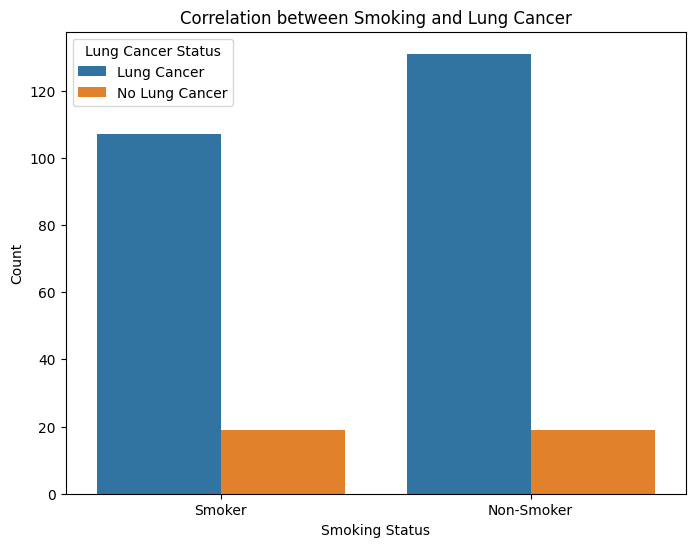

In [10]:
# bar plot showing the correlation between smoking and lung cancer
data['Smoking_Status'] = data['SMOKING'].map({1: 'Smoker', 2: 'Non-Smoker'})
data['Lung_Cancer_Status'] = data['LUNG_CANCER'].map({0: 'No Lung Cancer', 1: 'Lung Cancer'})

plt.figure(figsize=(8, 6))
sns.countplot(x='Smoking_Status', hue='Lung_Cancer_Status', data=data)
plt.title('Correlation between Smoking and Lung Cancer')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.legend(title='Lung Cancer Status')
plt.show()

## Centralized Training

In the realm of machine learning, centralized learning refers to a training paradigm where a single, centralized entity or server is responsible for collecting, storing, and processing all the data for model training. This approach stands in contrast to decentralized or federated learning, where data is distributed across multiple devices or locations.

### Logistic Regression:

Logistic Regression is a statistical method used for binary classification, predicting the probability of an observation belonging to one of two classes. It is widely employed in machine learning when the dependent variable is categorical and represents two outcomes, typically coded as 0 and 1.


In [11]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
print(f"Confusion Matrix : \n{confusion_matrix(y_test, lr_pred)}\n")
print(f"Classification Report : \n{classification_report(y_test, lr_pred)}\n")
print(f"Logistic Regression is Accuracy {round(accuracy_score(y_test, lr_pred)*100, ndigits = 2)} %")

Confusion Matrix : 
[[ 8  4]
 [ 0 44]]

Classification Report : 
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       0.92      1.00      0.96        44

    accuracy                           0.93        56
   macro avg       0.96      0.83      0.88        56
weighted avg       0.93      0.93      0.92        56


Logistic Regression is Accuracy 92.86 %


### Random Forest:

Random Forest is an ensemble learning algorithm widely used in machine learning for both classification and regression tasks. It operates by constructing a multitude of decision trees during training and outputs the mode (for classification) or the mean (for regression) of the individual trees for predictions.

#### How Random Forest Works

1. **Bootstrap Sampling (Bagging):** Random Forest starts by creating multiple random subsets of the original dataset through a process called bootstrap sampling. This involves randomly selecting samples with replacement, resulting in diverse subsets for each tree.

2. **Feature Randomization:** For each tree, a random subset of features is considered at each split. This helps to introduce diversity among the trees and prevents the dominance of one particular feature.

3. **Building Decision Trees:** Decision trees are constructed using the bootstrapped datasets and random subsets of features. Each tree in the forest is grown deep, often without pruning, to capture complex relationships in the data.

4. **Voting (Classification) or Averaging (Regression):** During prediction, the Random Forest aggregates the outputs of all individual trees. For classification tasks, the mode (most frequent class) is taken as the final prediction. For regression tasks, the mean of all predictions is considered.

#### Advantages of Random Forest

- **Robust to Overfitting:** The ensemble nature of Random Forest helps mitigate overfitting, as the aggregation of multiple trees tends to generalize well to unseen data.
  
- **High Accuracy:** Random Forest often provides high accuracy in both classification and regression tasks due to the combination of diverse decision trees.

- **Feature Importance:** The algorithm provides a measure of feature importance, helping in identifying the most relevant features in the dataset.

- **Handles Missing Values:** Random Forest can effectively handle missing values in the dataset without a need for imputation.

#### Use Cases

Random Forest is suitable for a wide range of applications, including but not limited to:

- Classification tasks in areas such as finance, healthcare, and image recognition.
- Regression tasks for predicting numerical values, like stock prices or housing prices.
- Identifying important features in datasets.

#### Conclusion

Random Forest is a powerful and versatile machine learning algorithm that leverages the strength of multiple decision trees to provide robust and accurate predictions. Its ability to handle various types of data and avoid overfitting makes it a popular choice in the machine learning community.


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


rfc = RandomForestClassifier(max_depth=max_depth, random_state = random_state) 
rfc.fit(x_train, y_train)
rfc_pred = rfc.predict(x_test)
print(f"Confusion Matrix: \n{confusion_matrix(y_test, rfc_pred)}\n")
print(f"Report:\n{classification_report(y_test, rfc_pred)}")
print(f"Random Forest Classifier Accuracy is {round(accuracy_score(y_test, rfc_pred)*100, ndigits = 2)} %")

Confusion Matrix: 
[[ 6  6]
 [ 0 44]]

Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        12
           1       0.88      1.00      0.94        44

    accuracy                           0.89        56
   macro avg       0.94      0.75      0.80        56
weighted avg       0.91      0.89      0.88        56

Random Forest Classifier Accuracy is 89.29 %


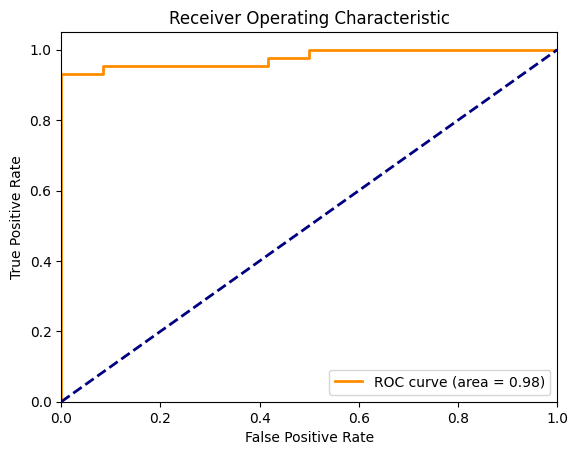

In [13]:
# create ROC curve
from sklearn.metrics import roc_curve, auc

y_probs = rfc.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Berechne AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC-Kurve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [14]:
data.drop("LUNG_CANCER", axis=1).columns

Index(['AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE',
       'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING',
       'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
       'SWALLOWING DIFFICULTY', 'CHEST PAIN', 'GENDER_Female', 'GENDER_Male',
       'Smoking_Status', 'Lung_Cancer_Status'],
      dtype='object')

In [15]:
data = data.drop("Smoking_Status", axis=1)
data = data.drop("Lung_Cancer_Status", axis=1)

                  Feature  Importance
0                     AGE    0.226893
7                ALLERGY     0.077366
2          YELLOW_FINGERS    0.072726
9       ALCOHOL CONSUMING    0.072202
4           PEER_PRESSURE    0.067687
5         CHRONIC DISEASE    0.066555
6                FATIGUE     0.057678
10               COUGHING    0.048710
12  SWALLOWING DIFFICULTY    0.046567
8                WHEEZING    0.044450
13             CHEST PAIN    0.043529
3                 ANXIETY    0.042386
11    SHORTNESS OF BREATH    0.036251
14          GENDER_Female    0.034021
1                 SMOKING    0.033342
15            GENDER_Male    0.029636


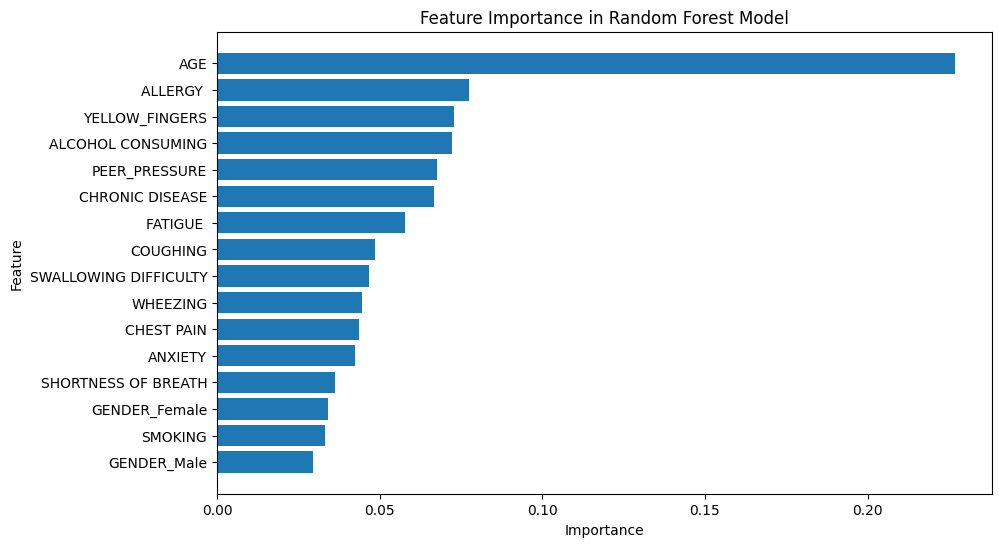

In [16]:
feature_importance_df = pd.DataFrame({'Feature': data.drop("LUNG_CANCER", axis=1).columns, 'Importance': rfc.feature_importances_})
 
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)
 
# sort by importance
feature_importances = feature_importance_df.sort_values(by='Importance', ascending=False)
 
# bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

### SVM:

Support Vector Machines (SVM) are a powerful class of supervised learning algorithms used for classification and regression tasks. SVMs are particularly effective in high-dimensional spaces and are widely used in machine learning and data analysis.

#### Overview

At its core, an SVM works by finding the optimal hyperplane that separates data points into different classes. The hyperplane is chosen such that it maximally separates the instances of different classes while maintaining a margin of separation. The instances that lie on the edges of the margin are called support vectors, hence the name of the algorithm.

####  Key Concepts

1. **Hyperplane:** In a two-dimensional space, a hyperplane is a simple line, while in higher dimensions, it becomes a hyperplane. SVM aims to find the hyperplane that best separates data points of different classes.

2. **Margin:** The margin is the distance between the hyperplane and the nearest data point from either class. SVM seeks to maximize this margin, providing robustness to the model.

3. **Support Vectors:** Support vectors are the data points that lie on the edges of the margin. These instances play a crucial role in determining the optimal hyperplane and are essential for the SVM algorithm.

####  Types of SVM

1. **Linear SVM:** This is suitable for linearly separable data, where a straight line can effectively divide the classes.

2. **Non-linear SVM (Kernel SVM):** When the data is not linearly separable, SVM can use a kernel function to map the input features into a higher-dimensional space, making it possible to find a hyperplane that separates the classes.

####  Advantages

- Effective in high-dimensional spaces.
- Robust to overfitting, especially in high-dimensi


In [17]:
svm = SVC(C = 100, gamma = 0.002)
svm.fit(x_train, y_train)
svm_pred = svm.predict(x_test)
print(f"Confusion Matrix: \n{confusion_matrix(y_test, svm_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, svm_pred)}\n")
print(f"Support Vector Machine Accuracy is {round(accuracy_score(y_test, svm_pred)*100, ndigits = 2)} %")

Confusion Matrix: 
[[ 9  3]
 [ 0 44]]

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        12
           1       0.94      1.00      0.97        44

    accuracy                           0.95        56
   macro avg       0.97      0.88      0.91        56
weighted avg       0.95      0.95      0.94        56


Support Vector Machine Accuracy is 94.64 %


### Evaluation:

Text Text

## Federated Learning with Flower

#### What is Federated Learning?
Federated Learning is a decentralized machine learning approach that allows model training across multiple devices or edge nodes without the need to transfer raw data to a central server. In this paradigm, models are trained locally on individual devices using their respective data, and only the model updates are transmitted to a central server, where they are aggregated to improve the global model.

##### How Federated Learning Works

The Federated Learning process typically involves the following steps:

1. **Initialization:**
   - A global model is initialized on a central server.

2. **Local Training:**
   - The global model is sent to participating devices.
   - Each device trains the model using its local data, making updates based on its specific context.

3. **Model Updates:**
   - Only the model updates, not the raw data, are sent back to the central server.

4. **Aggregation:**
   - The central server aggregates the received updates from all participating devices to improve the global model.

5. **Iteration:**
   - Steps 2-4 are repeated iteratively to refine the global model collaboratively.

##### Advantages of Federated Learning

- **Privacy Preservation:**
  - Federated Learning helps address privacy concerns by keeping data localized. Raw data never leaves individual devices, reducing the risk of sensitive information exposure.

- **Edge Computing:**
  - It leverages edge devices for local model training, making it suitable for scenarios with resource-constrained or bandwidth-limited devices.

- **Decentralized Training:**
  - Enables training on diverse datasets, reflecting variations in local environments and user behaviors.

- **Reduced Communication Overhead:**
  - Transmitting only model updates instead of raw data minimizes communication overhead, making it efficient for devices with limited network capabilities.

##### Challenges and Considerations

- **Heterogeneity:**
  - Devices may have diverse data distributions and capabilities, requiring careful consideration in model aggregation.

- **Security Concerns:**
  - Federated Learning introduces new security challenges, such as the potential for model inversion attacks. Robust security measures must be implemented.

- **Communication Delays:**
  - Depending on the network conditions, communication delays between devices and the central server may impact the efficiency of the training process.

##### Conclusion

Federated Learning offers a privacy-preserving and collaborative approach to machine learning, making it well-suited for scenarios where data privacy is a priority or where edge devices play a crucial role in the learning process.

#### What is Flower?

Flower is a Python library designed to facilitate federated learning, a machine learning paradigm where the model is trained across decentralized devices or servers holding local data samples. The goal is to enable collaborative model training without sharing raw data.

##### Features

Flower offers several key features for federated learning:

1. **Decentralized Training**

Flower provides tools for training machine learning models across multiple devices or servers in a decentralized manner. Each device holds its local dataset, and model updates are aggregated without exchanging raw data.

2. **Privacy-Preserving**

By design, federated learning aims to preserve the privacy of local data. Flower ensures that the raw data never leaves the local device, as only model updates are shared during the training process.

3. **Scalability**

The library is designed to scale efficiently, making it suitable for federated learning scenarios involving a large number of devices or servers. This scalability is essential for applications with diverse and extensive datasets.

4. **Compatibility with PyTorch and TensorFlow**

Flower is compatible with popular deep learning frameworks like PyTorch and TensorFlow, making it accessible to a broad audience. This allows practitioners to leverage familiar tools while adopting federated learning techniques.


### Training preperation

In [18]:
NUM_CLIENTS = 3
num_rounds = 5

In [19]:
def split_data_for_clients(x_train, y_train, x_test, y_test, num_clients):
    chunk_size_train = len(x_train) // num_clients
    chunk_size_test = len(x_test) // num_clients

    remainder_train = len(x_train) % num_clients
    remainder_test = len(x_test) % num_clients

    x_train_chunks, y_train_chunks, x_test_chunks, y_test_chunks = [], [], [], []

    for i in range(num_clients):
        start_train = i * chunk_size_train
        end_train = start_train + chunk_size_train + (1 if i < remainder_train else 0)

        start_test = i * chunk_size_test
        end_test = start_test + chunk_size_test + (1 if i < remainder_test else 0)

        x_train_chunks.append(x_train[start_train:end_train])
        y_train_chunks.append(y_train[start_train:end_train])
        x_test_chunks.append(x_test[start_test:end_test])
        y_test_chunks.append(y_test[start_test:end_test])

    return x_train_chunks, y_train_chunks, x_test_chunks, y_test_chunks

x_train_chunks, y_train_chunks, x_test_chunks, y_test_chunks = split_data_for_clients(
    x_train, y_train, x_test, y_test, NUM_CLIENTS
)
# print shape of each chunk
for i in range(len(x_train_chunks)):
    print(f"Client {i+1}: {x_train_chunks[i].shape}, {y_train_chunks[i].shape}, {x_test_chunks[i].shape}, {y_test_chunks[i].shape}")

Client 1: (74, 16), (74,), (19, 16), (19,)
Client 2: (73, 16), (73,), (19, 16), (19,)
Client 3: (73, 16), (73,), (18, 16), (18,)


### Random Forest

#### Functions

In [20]:
from typing import List

In [21]:
def set_params(
    model: RandomForestClassifier, params: List[np.ndarray]
) -> RandomForestClassifier:
    model.n_estimators = int(params[0])
    model.max_depth = int(params[1])
    model.min_samples_split = int(params[2])
    model.min_samples_leaf = int(params[3])
    return model

In [22]:
def get_params(model: RandomForestClassifier) -> List[np.ndarray]:
    params = [
        model.n_estimators,
        model.max_depth,
        model.min_samples_split,
        model.min_samples_leaf,
    ]
    return params

#### Script

In [61]:
# Flower-Client-Definition
class RandomForestClient(fl.client.NumPyClient):
    def __init__(self, X_train, y_train, X_test, y_test, local_epochs):
        self.model = RandomForestClassifier(max_depth=max_depth, random_state = random_state)
        self.X_train, self.y_train = X_train, y_train
        self.X_test, self.y_test = X_test, y_test
        self.local_epochs = local_epochs

    def get_parameters(self, config):
        return get_params(self.model)

    def fit(self, parameters, config):
        set_params(self.model, parameters)
        for _ in range(self.local_epochs):
            self.model.fit(self.X_train, self.y_train)
            return self.get_parameters(config), len(self.X_train), {}

    def evaluate(self, parameters, config):
        set_params(self.model, parameters)
        accuracy = self.model.score(self.X_test, self.y_test)
        return accuracy, len(self.X_test), {}

# Initialisiere die Clients und starte das föderierte Training
client_data = list(zip(x_train_chunks, y_train_chunks, x_test_chunks, y_test_chunks))
client_models = [RandomForestClient(X_train, y_train, X_test, y_test, local_epochs=1) for X_train, y_train, X_test, y_test in zip(x_train_chunks, y_train_chunks, x_test_chunks, y_test_chunks)]

In [62]:
client_counter = 0
for client in client_models:
    client_counter += 1
    X_train, y_train, X_test, y_test = client.X_train, client.y_train, client.X_test, client.y_test
    
    # Trainiere das Modell
    client.model.fit(X_train, y_train)

    # Evaluiere das Modell
    accuracy = client.model.score(X_test, y_test)
    print(f"Client {client_counter} Accuracy: {accuracy}")

Client 1 Accuracy: 0.7894736842105263
Client 2 Accuracy: 0.8947368421052632
Client 3 Accuracy: 0.8888888888888888


In [74]:
plt.plot(client_counter, accuracy, marker='o', linestyle='-', color='b')

# Achsentitel und Diagrammtitel hinzufügen
plt.xlabel('Client)
plt.ylabel('Accuracy')
plt.title('Accuracy')

# Gitterlinien hinzufügen
plt.grid(True)

# Diagramm anzeigen
plt.show()

SyntaxError: EOL while scanning string literal (3880027487.py, line 4)

In [63]:
def client_fn(cid: str) -> RandomForestClient:
    X_train, y_train, X_test, y_test = client_data[int(cid)]
    return RandomForestClient(X_train, y_train, X_test, y_test)

In [64]:
forest = client_models[0]
print(forest.model.get_params())
forest.get_parameters({})

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


[100, 10, 2, 1]

In [65]:
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=1,
    min_available_clients=1,
)

client_resources = {"num_cpus" : 1, "num_gpus" : 0.0}
if DEVICE.type == "cuda":
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}

# flower simulation setup
result = fl.simulation.start_simulation(
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
    client_fn= lambda i: client_models[int(i)], #client_fn,
)

WARNING flwr 2024-01-23 16:18:40,215 | fedavg.py:117 | 
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO flwr 2024-01-23 16:18:40,218 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2024-01-23 16:18:44,484	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-01-23 16:18:47,242 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 5447713178.0, 'node:__internal_head__': 1.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0}
INFO flwr 2024-01-23 16:18:47,242 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-01-23 16:18:47,243 | app.py:227 | No `clie

In [66]:
# Global Model FedAvg
print(result)

History (loss, distributed):
	round 1: 0.8421052631578947
	round 2: 0.8378378378378378
	round 3: 0.8918918918918919
	round 4: 0.8918918918918919
	round 5: 0.8378378378378378



### Dynamic epochs

In [69]:
client_models = [RandomForestClient(X_train, y_train, X_test, y_test, local_epochs=1) for X_train, y_train, X_test, y_test in zip(x_train_chunks, y_train_chunks, x_test_chunks, y_test_chunks)]

strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=1,
    min_available_clients=1,
)

client_counter = 0
for client in client_models:
    client_counter += 1
    X_train, y_train, X_test, y_test = client.X_train, client.y_train, client.X_test, client.y_test
    
    # Trainiere das Modell
    client.model.fit(X_train, y_train)

    # Evaluiere das Modell
    accuracy = client.model.score(X_test, y_test)
    print(f"Client {client_counter} Accuracy: {accuracy}")


client_resources = {"num_cpus" : 1, "num_gpus" : 0.0}
if DEVICE.type == "cuda":
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}

# flower simulation setup
result = fl.simulation.start_simulation(
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
    client_fn= lambda i: client_models[int(i)], #client_fn,
)

WARNING flwr 2024-01-23 16:20:11,806 | fedavg.py:117 | 
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.



Client 1 Accuracy: 0.7894736842105263
Client 2 Accuracy: 0.8947368421052632


INFO flwr 2024-01-23 16:20:12,414 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)


Client 3 Accuracy: 0.8888888888888888
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


2024-01-23 16:20:16,918	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-01-23 16:20:19,850 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 5389563904.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2024-01-23 16:20:19,851 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-01-23 16:20:19,852 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2024-01-23 16:20:19,853 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-01-23 16:20:19,885 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO flwr 2024-01-23 16:20:19,886 | server.py:89 | Initializing global parameters
INFO flwr 2024-01-23 16:20:19,888 | server.py:276 | Requesting initial parameters from one random client
(

(raylet) [2024-01-23 16:20:36,970 E 25852 1357331] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-01-23_16-20-14_147008_23787 is over 95% full, available space: 7008681984; capacity: 250790436864. Object creation will fail if spilling is required.
(raylet) [2024-01-23 16:20:47,037 E 25852 1357331] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-01-23_16-20-14_147008_23787 is over 95% full, available space: 7008542720; capacity: 250790436864. Object creation will fail if spilling is required.
(raylet) [2024-01-23 16:20:57,115 E 25852 1357331] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-01-23_16-20-14_147008_23787 is over 95% full, available space: 7007072256; capacity: 250790436864. Object creation will fail if spilling is required.
(raylet) [2024-01-23 16:21:07,197 E 25852 1357331] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-01-23_16-20-14_147008_23787 is over 95% full, available space: 7006617600; capacity: 250790436864. Object crea

In [73]:
# dieser komplette block ist verglichen mit der aktuellen github version neu
# hier soll versucht werden mit unterschiedlichen lokalen epochen zu trainieren

results = []

strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=1,
    min_available_clients=1,
)

for local_epochs in [1,3,5]:

    client_models = [RandomForestClient(X_train, y_train, X_test, y_test, local_epochs=local_epochs) for X_train, y_train, X_test, y_test in zip(x_train_chunks, y_train_chunks, x_test_chunks, y_test_chunks)]

    strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=1,
        min_available_clients=1,
    )

    client_counter = 0
    for client in client_models:
        client_counter += 1
        X_train, y_train, X_test, y_test = client.X_train, client.y_train, client.X_test, client.y_test
        
        # Trainiere das Modell
        client.model.fit(X_train, y_train)

    # flower simulation setup
    result = fl.simulation.start_simulation(
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=num_rounds),
        strategy=strategy,
        client_fn= lambda i: client_models[int(i)], #client_fn,
    )
    # Ergebnisse speichern
    results.append((local_epochs, result))

WARNING flwr 2024-01-23 16:26:14,052 | fedavg.py:117 | 
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

WARNING flwr 2024-01-23 16:26:14,057 | fedavg.py:117 | 
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.



Client 1 Accuracy: 0.7894736842105263
Client 2 Accuracy: 0.8947368421052632


INFO flwr 2024-01-23 16:26:14,875 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)


Client 3 Accuracy: 0.8888888888888888


2024-01-23 16:26:20,645	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-01-23 16:26:23,291 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 5348110336.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-01-23 16:26:23,294 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-01-23 16:26:23,295 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2024-01-23 16:26:23,295 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-01-23 16:26:23,325 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO flwr 2024-01-23 16:26:23,326 | server.py:89 | Initializing global parameters
INFO flwr 2024-01-23 16:26:23,328 | server.py:276 | Requesting initial parameters from one random client
(

Client 1 Accuracy: 0.7894736842105263
Client 2 Accuracy: 0.8947368421052632


INFO flwr 2024-01-23 16:26:32,364 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)


Client 3 Accuracy: 0.8888888888888888


2024-01-23 16:26:36,908	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-01-23 16:26:39,768 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 5436366439.0, 'CPU': 8.0, 'node:__internal_head__': 1.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0}
INFO flwr 2024-01-23 16:26:39,769 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-01-23 16:26:39,770 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2024-01-23 16:26:39,771 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-01-23 16:26:39,814 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO flwr 2024-01-23 16:26:39,817 | server.py:89 | Initializing global parameters
INFO flwr 2024-01-23 16:26:39,821 | server.py:276 | Requesting initial parameters from one random client
(

Client 1 Accuracy: 0.7894736842105263
Client 2 Accuracy: 0.8947368421052632


INFO flwr 2024-01-23 16:26:53,212 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)


Client 3 Accuracy: 0.8888888888888888


2024-01-23 16:27:01,076	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-01-23 16:27:06,548 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 5214640538.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-01-23 16:27:06,551 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-01-23 16:27:06,553 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2024-01-23 16:27:06,556 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-01-23 16:27:06,655 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO flwr 2024-01-23 16:27:06,695 | server.py:89 | Initializing global parameters
INFO flwr 2024-01-23 16:27:06,753 | server.py:276 | Requesting initial parameters from one random client
(

Ergebnisse für 1 lokale Epochen: History (loss, distributed):
	round 1: 0.8378378378378378
	round 2: 0.8378378378378378
	round 3: 0.8378378378378378
	round 4: 0.8918918918918919
	round 5: 0.8378378378378378

Ergebnisse für 3 lokale Epochen: History (loss, distributed):
	round 1: 0.8378378378378378
	round 2: 0.8378378378378378
	round 3: 0.8918918918918919
	round 4: 0.8378378378378378
	round 5: 0.8421052631578947

Ergebnisse für 5 lokale Epochen: History (loss, distributed):
	round 1: 0.8378378378378378
	round 2: 0.8421052631578947
	round 3: 0.8378378378378378
	round 4: 0.8378378378378378
	round 5: 0.8918918918918919



(raylet) [2024-01-23 16:27:20,030 E 26386 1364895] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-01-23_16-26-55_083793_23787 is over 95% full, available space: 6995570688; capacity: 250790436864. Object creation will fail if spilling is required.
(raylet) [2024-01-23 16:27:30,116 E 26386 1364895] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-01-23_16-26-55_083793_23787 is over 95% full, available space: 6982897664; capacity: 250790436864. Object creation will fail if spilling is required.
(raylet) [2024-01-23 16:27:40,196 E 26386 1364895] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-01-23_16-26-55_083793_23787 is over 95% full, available space: 6975225856; capacity: 250790436864. Object creation will fail if spilling is required.
(raylet) [2024-01-23 16:27:50,265 E 26386 1364895] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-01-23_16-26-55_083793_23787 is over 95% full, available space: 6898049024; capacity: 250790436864. Object crea

In [ ]:
# Ergebnisse ausgeben
for local_epochs, result in results:
    #print(result)
    print(f"Ergebnisse für {local_epochs} lokale Epochen: {result}")

## Working with biased datasets

In [106]:
# Evaluate the influence of different data distribution in the nodes

# filter the data for the different smoking status
smokers = data[data['SMOKING'] == 1]
non_smokers = data[data['SMOKING'] == 2]

# pick a large fraction of smokers and non-smokers for different clients
smoker_subset = smokers.sample(frac=0.9)
nonsmoker_subset = non_smokers.sample(frac=0.9)

# combine the remaining smokers and non-smokers into one dataset
remaining_smokers = smokers.drop(smoker_subset.index)
remaining_nonsmokers = non_smokers.drop(nonsmoker_subset.index)

# create final datasets for the clients
client1_data = pd.concat([smoker_subset, remaining_nonsmokers])
client2_data = pd.concat([nonsmoker_subset, remaining_smokers])

In [107]:
# check if client1_data has the right amount of smokers and non-smokers
print(client1_data['SMOKING'].value_counts())
print(client2_data['SMOKING'].value_counts())

SMOKING
1    113
2     15
Name: count, dtype: int64
SMOKING
2    135
1     13
Name: count, dtype: int64


value_counts shows that the two client datasets are strongly biased

In [108]:
# create train_test_split for the clients
x1 = client1_data.drop("LUNG_CANCER", axis = 1)
y1 = client1_data["LUNG_CANCER"]

x2 = client2_data.drop("LUNG_CANCER", axis = 1)
y2 = client2_data["LUNG_CANCER"]

scaler = StandardScaler()
x1 = scaler.fit_transform(x1)
x1_train, x1_test, y1_train, y1_test = train_test_split(x1,y1, test_size=0.2, random_state=random_state)

x2 = scaler.fit_transform(x2)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2,y2, test_size=0.2, random_state=random_state)

print(f"Shape of client1 training data : {x1_train.shape}, {y1_train.shape}")
print(f"Shape of client1 testing data : {x1_test.shape}, {y1_test.shape}")

print(f"Shape of client2 training data : {x2_train.shape}, {y2_train.shape}")
print(f"Shape of client2 testing data : {x2_test.shape}, {y2_test.shape}")


Shape of client1 training data : (102, 16), (102,)
Shape of client1 testing data : (26, 16), (26,)
Shape of client2 training data : (118, 16), (118,)
Shape of client2 testing data : (30, 16), (30,)


In [110]:
local_epochs = 5
# Rest des Codes bleibt unverändert

client1_model = RandomForestClient(x1_train, y1_train, x1_test, y1_test, local_epochs=local_epochs)
client2_model = RandomForestClient(x2_train, y2_train, x2_test, y2_test, local_epochs=local_epochs)

# client_models combines the two clients
biased_client_models = [client1_model, client2_model]

# Anpassung der client_fn für die Simulation
def client_fn(cid: str) -> RandomForestClient:
    if cid == "0":
        return client1_model
    elif cid == "1":
        return client2_model
    else:
        raise ValueError("Ungültige Client-ID")

In [111]:
for client in biased_client_models:
    # Trainiere das Modell
    client.model.fit(client.X_train, client.y_train)

In [112]:
for client in biased_client_models:
    X_train, y_train, X_test, y_test = client.X_train, client.y_train, client.X_test, client.y_test
    
    # Trainiere das Modell
    client.model.fit(X_train, y_train)

    # Evaluiere das Modell
    accuracy = client.model.score(X_test, y_test)
    print(f"Client Accuracy: {accuracy}")

Client Accuracy: 0.9230769230769231
Client Accuracy: 0.8666666666666667


In [113]:
forest = biased_client_models[0]
print(forest.model.get_params())
forest.get_parameters({})

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


[100, 10, 2, 1]

In [114]:
# flower simulation setup
biased_result = fl.simulation.start_simulation(
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_fn= lambda i: biased_client_models[int(i)], #client_fn
)

INFO flwr 2024-01-23 15:38:01,018 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2024-01-23 15:38:05,383	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-01-23 15:38:08,793 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 5375699354.0, 'node:__internal_head__': 1.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2024-01-23 15:38:08,794 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-01-23 15:38:08,796 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2024-01-23 15:38:08,798 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-01-23 15:38:08,831 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO flwr 2024-01-23 15:38:08,833 | server.py:89 | Initi

(raylet) [2024-01-23 15:38:25,435 E 22134 1302804] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-01-23_15-38-02_631442_15826 is over 95% full, available space: 6255640576; capacity: 250790436864. Object creation will fail if spilling is required.
(raylet) [2024-01-23 15:38:35,517 E 22134 1302804] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-01-23_15-38-02_631442_15826 is over 95% full, available space: 6245732352; capacity: 250790436864. Object creation will fail if spilling is required.
(raylet) [2024-01-23 15:38:45,587 E 22134 1302804] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-01-23_15-38-02_631442_15826 is over 95% full, available space: 6242574336; capacity: 250790436864. Object creation will fail if spilling is required.
(raylet) [2024-01-23 15:38:55,649 E 22134 1302804] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-01-23_15-38-02_631442_15826 is over 95% full, available space: 6275837952; capacity: 250790436864. Object crea

In [74]:
print(biased_result)

History (loss, distributed):
	round 1: 0.9464285714285714
	round 2: 0.9464285714285714
	round 3: 0.9464285714285714
	round 4: 0.9464285714285714
	round 5: 0.9464285714285714

